In [1]:
# Data exploration

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, mean_absolute_error

%matplotlib inline

In [2]:
url = 'https://raw.githubusercontent.com/WhyseRabbit/med-cabinet-ds/feature/tensor_effects/data/cannabis.csv'
df = pd.read_csv(url)
df.head()

,Strain,Type,Rating,Effects,Flavor,Description
0,100-Og,hybrid,4.0,"Creative,Energetic,Tingly,Euphoric,Relaxed","Earthy,Sweet,Citrus",$100 OG is a 50/50 hybrid strain that packs a ...
1,98-White-Widow,hybrid,4.7,"Relaxed,Aroused,Creative,Happy,Energetic","Flowery,Violet,Diesel",The ‘98 Aloha White Widow is an especially pot...
2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1024 is a sativa-dominant hybrid bred in Spain...
3,13-Dawgs,hybrid,4.2,"Tingly,Creative,Hungry,Relaxed,Uplifted","Apricot,Citrus,Grapefruit",13 Dawgs is a hybrid of G13 and Chemdawg genet...
4,24K-Gold,hybrid,4.6,"Happy,Relaxed,Euphoric,Uplifted,Talkative","Citrus,Earthy,Orange","Also known as Kosher Tangie, 24k Gold is a 60%..."


In [3]:
df.columns

Index(['Strain', 'Type', 'Rating', 'Effects', 'Flavor', 'Description'], dtype='object')

In [4]:
# imports
import nltk
nltk.download(['punkt', 'wordnet', 'stopwords'])
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import re

# define function tokenize

def tokenize(text):
    '''
    for text strings to be tokenized (tokens)
    removing stop words
    Lemmatization
    '''
    tokens = word_tokenize(text)
    tokens = re.sub('[^a-zA-Z 0-9]', '', text)
    tokens = tokens.lower().split()
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [lemmatizer.lemmatize(w.lower().strip()) for w in tokens]
    
    return tokens

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/marianvinas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/marianvinas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/marianvinas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
df['Description'].value_counts(normalize=True)[:10]

None                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     0.001726
B-Witched by Ocean Grown Seeds is a magical cross of arcane genetics. By combining OGS Wizard’s Potion and the famous Witches Weed, a frosted herbaceous phantasm is brought to life, exhibiting notes of grape, forest floor, and grapefruit. Its terpene profile has also been described as “cupcake-ish.” The effects of B-Witched are enthralling, muting stress, anxiety, and nausea with ease.                                                                                                  

In [7]:
# Using the tokenize function
df['Description'] = df['Description'].apply(str)
df['base_tokens'] = df['Description'].apply(tokenize)
df['base_tokens'].head()

0    [100, og, 5050, hybrid, strain, pack, strong, ...
1    [98, aloha, white, widow, especially, potent, ...
2    [1024, sativadominant, hybrid, bred, spain, me...
3    [13, dawgs, hybrid, g13, chemdawg, genetics, b...
4    [also, known, kosher, tangie, 24k, gold, 60, i...
Name: base_tokens, dtype: object

In [8]:
df[['Description', 'base_tokens']][:10]


,Description,base_tokens
0,$100 OG is a 50/50 hybrid strain that packs a ...,"[100, og, 5050, hybrid, strain, pack, strong, ..."
1,The ‘98 Aloha White Widow is an especially pot...,"[98, aloha, white, widow, especially, potent, ..."
2,1024 is a sativa-dominant hybrid bred in Spain...,"[1024, sativadominant, hybrid, bred, spain, me..."
3,13 Dawgs is a hybrid of G13 and Chemdawg genet...,"[13, dawgs, hybrid, g13, chemdawg, genetics, b..."
4,"Also known as Kosher Tangie, 24k Gold is a 60%...","[also, known, kosher, tangie, 24k, gold, 60, i..."
5,3 Bears OG by Mephisto Genetics is an autoflow...,"[3, bear, og, mephisto, genetics, autoflowerin..."
6,"The 3 Kings marijuana strain, a holy trinity o...","[3, king, marijuana, strain, holy, trinity, he..."
7,The indica-dominant 303 OG is a Colorado strai...,"[indicadominant, 303, og, colorado, strain, br..."
8,3D CBD from Snoop Dogg’s branded line of canna...,"[3d, cbd, snoop, doggs, branded, line, cannabi..."
9,"Also known as Optimus Prime, the indica-domina...","[also, known, optimus, prime, indicadominant, ..."


In [9]:
# Create a function which takes a corpus of document and returns a dataframe of word counts

from collections import Counter

def count(docs):
    '''This function takes a list of tokenized documents as input and returns
    a dataframe with frequency counts and rank for each token.
    
    # Arguments
        docs: list, tokenized list of documents
        
    # Returns
        wc: dataframe, 
    '''
    
    word_counts = Counter()
    appears_in = Counter()

    total_docs = len(docs)

    for doc in docs:
        word_counts.update(doc)
        appears_in.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())

    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    wc['pct_total'] = wc['count'].apply(lambda x: x / total)

    wc = wc.sort_values(by='rank')
    wc['cul_pct_total'] = wc['pct_total'].cumsum()

    t2 = zip(appears_in.keys(), appears_in.values())
    ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
    wc = ac.merge(wc, on='word')

    wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)

    return wc.sort_values(by='rank')

In [10]:
wc = count(df['base_tokens'])
print(wc.shape)
wc.head()

(9985, 7)


,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
1,strain,1811,2954,1.0,0.027157,0.027157,0.770311
13,effect,1294,1581,2.0,0.014535,0.041692,0.550404
26,hybrid,1064,1262,3.0,0.011602,0.053294,0.452573
34,og,480,1021,4.0,0.009387,0.062681,0.204168
165,aroma,940,985,5.0,0.009056,0.071737,0.399830


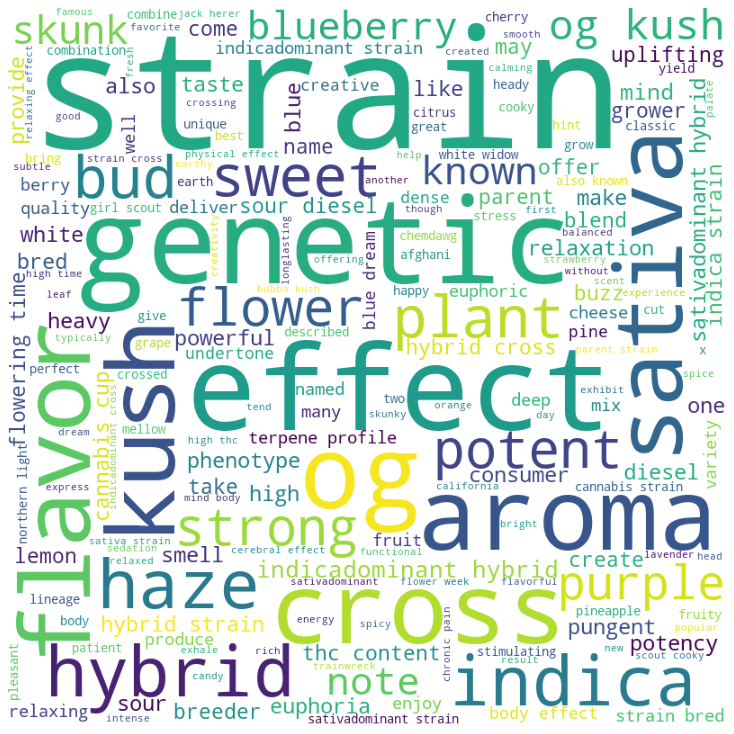

In [11]:
from wordcloud import WordCloud

comment_words = ''
stop_words = set(stopwords.words('english'))

for val in df.base_tokens:
    val = str(val)
    tokens = word_tokenize(val)
    tokens = re.sub('[^a-zA-Z 0-9]', '', val)
    tokens = tokens.lower().split()
    lemmatizer = WordNetLemmatizer()
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [lemmatizer.lemmatize(w.lower().strip()) for w in tokens]
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                     background_color='white',
                     stopwords = stop_words,
                     min_font_size = 10).generate(comment_words)

plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [16]:
new_data = df.copy()

In [17]:
new_data = pd.get_dummies(new_data, columns=["Type"])
new_data

,Strain,Rating,Effects,Flavor,Description,description,base_tokens,Type_hybrid,Type_indica,Type_sativa
0,100-Og,4.0,"Creative,Energetic,Tingly,Euphoric,Relaxed","Earthy,Sweet,Citrus",$100 OG is a 50/50 hybrid strain that packs a ...,$100 OG is a 50/50 hybrid strain that packs a ...,"[100, og, 5050, hybrid, strain, pack, strong, ...",1,0,0
1,98-White-Widow,4.7,"Relaxed,Aroused,Creative,Happy,Energetic","Flowery,Violet,Diesel",The ‘98 Aloha White Widow is an especially pot...,The ‘98 Aloha White Widow is an especially pot...,"[98, aloha, white, widow, especially, potent, ...",1,0,0
2,1024,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1024 is a sativa-dominant hybrid bred in Spain...,1024 is a sativa-dominant hybrid bred in Spain...,"[1024, sativadominant, hybrid, bred, spain, me...",0,0,1
3,13-Dawgs,4.2,"Tingly,Creative,Hungry,Relaxed,Uplifted","Apricot,Citrus,Grapefruit",13 Dawgs is a hybrid of G13 and Chemdawg genet...,13 Dawgs is a hybrid of G13 and Chemdawg genet...,"[13, dawgs, hybrid, g13, chemdawg, genetics, b...",1,0,0
4,24K-Gold,4.6,"Happy,Relaxed,Euphoric,Uplifted,Talkative","Citrus,Earthy,Orange","Also known as Kosher Tangie, 24k Gold is a 60%...","Also known as Kosher Tangie, 24k Gold is a 60%...","[also, known, kosher, tangie, 24k, gold, 60, i...",1,0,0
...,...,...,...,...,...,...,...,...,...,...
2346,Zeus-Og,4.7,"Happy,Uplifted,Relaxed,Euphoric,Energetic","Earthy,Woody,Pine",Zeus OG is a hybrid cross between Pineapple OG...,Zeus OG is a hybrid cross between Pineapple OG...,"[zeus, og, ahybrid, cross, pineapple, og, dead...",1,0,0
2347,Zkittlez,4.6,"Relaxed,Happy,Euphoric,Uplifted,Sleepy","Sweet,Berry,Grape",Zkittlez is an indica-dominant mix of Grape Ap...,Zkittlez is an indica-dominant mix of Grape Ap...,"[zkittlez, indicadominant, mix, grape, ape, gr...",0,1,0
2348,Zombie-Kush,5.0,"Relaxed,Sleepy,Talkative,Euphoric,Happy","Earthy,Sweet,Spicy/Herbal",Zombie Kush by Ripper Seeds comes from two dif...,Zombie Kush by Ripper Seeds comes from two dif...,"[zombie, kush, ripper, seed, come, two, differ...",0,1,0
2349,Zombie-Og,4.4,"Relaxed,Sleepy,Euphoric,Happy,Hungry","Sweet,Earthy,Pungent",If you’re looking to transform into a flesh-ea...,If you’re looking to transform into a flesh-ea...,"[youre, looking, transform, flesheating, monst...",0,1,0


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

# initialize pipeline

# Create pipeline components
vect = TfidfVectorizer(stop_words='english', ngram_range=(1,2))
svm = LinearSVC()

# Get sparse dtm
dtm = vect.fit_transform(new_data.Description)

# Convert to dataframe
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
dtm.shape

pipe = Pipeline([
    ('vect', vect),
    ('clf', svm)
])

# split data and remove NA values
new_data.dropna(inplace=True)
X = new_data['Description']
y = new_data['Type_hybrid']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# pipeline fit
pipe.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 TfidfVectorizer(ngram_range=(1, 2), stop_words='english')),
                ('clf', LinearSVC())])

In [19]:
y_preds = pipe.predict(X_test)
y_preds

array([1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,

In [20]:
mse = mean_squared_error(y_test, y_preds)
mse

0.23427331887201736

In [21]:
from math import sqrt

rmse = sqrt(mse)
rmse

0.48401789106604043

In [22]:
y_test.head(10)

584     1
370     0
1863    1
2126    1
259     0
890     1
2059    1
868     1
79      1
1722    0
Name: Type_hybrid, dtype: uint8

In [23]:
r2 = r2_score(y_test, y_preds)
r2

0.0616306683252289

In [24]:
mae = mean_absolute_error(y_test, y_preds)
mae

28.885032537960953

In [ ]:
# GridSearchCV

from sklearn.model_selection import GridSearchCV

target = new_data['Rating']

rfc = RandomForestClassifier()

pipe2 = Pipeline([('vect', vect), ('clf', rfc)])


parameters = {
    'vect__max_df': (0.7, 1.0),
    'vect__min_df': (.02, .05, .10),
    'vect__max_features':(500, 1500),
    'clf__n_estimators':(5, 10),
    'clf__max_depth':(5, 10, 15, 20)
}

grid_search = GridSearchCV(pipe2, parameters, cv=5, n_jobs=4, verbose=1)
grid_search.fit(new_data['Type_hybrid'], target)

In [27]:
grid_search.best_score_

0.7900216919739695

In [28]:
grid_search.best_params_

{'clf__max_depth': 15,
 'clf__n_estimators': 10,
 'vect__max_df': 0.7,
 'vect__max_features': 1500,
 'vect__min_df': 0.02}

In [29]:
from sklearn.metrics import accuracy_score

# Evaluate on test data
y_test = grid_search.predict(df.description)
accuracy_score(target, y_test)

0.8984815618221258

In [30]:
best_model = grid_search.best_estimator_
vect = best_model.named_steps['vect']
clf = best_model.named_steps['clf']